In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("bike").getOrCreate()
df = spark.read.option("header","true").csv("/content/drive/MyDrive/2017-fordgobike-tripdata.csv")

In [3]:
!pip install haversine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from haversine import haversine, Unit

haversine([45.7597, 4.8422], [48.8567, 2.3508])

392.2172595594006

In [5]:
import pyspark.pandas as ps

def getDistance(start_lat, start_long, end_lat, end_long):
    return round(
        haversine(
            [ float(start_lat), float(start_long) ],
            [ float(end_lat), float(end_long) ],
            unit=Unit.METERS
        ), 2
    )


In [6]:
from pyspark.sql.functions import udf

getDistanceUDF = udf(lambda a,b,c,d : getDistance(a,b,c,d) )
df = df.withColumn("Distance", getDistanceUDF(df["start_station_latitude"], df["start_station_longitude"], df["end_station_latitude"], df["end_station_longitude"]))

In [7]:
df.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_latitude: string (nullable = true)
 |-- start_station_longitude: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_latitude: string (nullable = true)
 |-- end_station_longitude: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- user_type: string (nullable = true)
 |-- member_birth_year: string (nullable = true)
 |-- member_gender: string (nullable = true)
 |-- pyment: string (nullable = true)
 |-- Distance: string (nullable = true)



In [8]:
df.select("Distance").show()

+--------+
|Distance|
+--------+
|  942.93|
| 3069.73|
|     0.0|
| 1046.62|
|  636.34|
|     0.0|
|     0.0|
|     0.0|
|     0.0|
|     0.0|
|   771.3|
|   771.3|
| 1517.35|
| 1517.35|
|  1422.6|
| 1050.26|
| 1050.26|
| 2856.34|
| 2856.34|
| 2859.25|
+--------+
only showing top 20 rows



 # 1-calculate the total distance for each bike and list the top 10

In [9]:
from pyspark.sql.functions import round

In [10]:
group_bike = df.groupBy("bike_id").agg({'Distance' : "sum"})\
                .withColumnRenamed("sum(Distance)", "Total Distance")
group_bike = group_bike.withColumn("T_Distance", round(group_bike["Total Distance"],2))
group_bike.show()

+-------+------------------+----------+
|bike_id|    Total Distance|T_Distance|
+-------+------------------+----------+
|   1159|207481.01999999996| 207481.02|
|   3606|          15315.78|  15315.78|
|   2904| 485315.9799999999| 485315.98|
|   1090|         207034.56| 207034.56|
|   2069| 427986.5600000002| 427986.56|
|   1512|         214180.63| 214180.63|
|   3414|          35948.43|  35948.43|
|    467|195744.99999999994|  195745.0|
|   2088|         377221.49| 377221.49|
|   1572|238461.14999999997| 238461.15|
|   3210| 98775.27000000002|  98775.27|
|    296|254031.78999999998| 254031.79|
|   1436|          91704.69|  91704.69|
|    691|         152689.23| 152689.23|
|   2136|449488.82000000007| 449488.82|
|    829| 377199.6700000001| 377199.67|
|   2162|239004.17999999996| 239004.18|
|   3281|32268.640000000003|  32268.64|
|   3650|36060.689999999995|  36060.69|
|   3517|          11817.57|  11817.57|
+-------+------------------+----------+
only showing top 20 rows



In [22]:
group_bike = group_bike.orderBy(group_bike["T_Distance"].desc())
group_bike_pd = group_bike.limit(10).toPandas()

Text(0.5, 1.0, 'Top 10 Bikes by Total Distance')

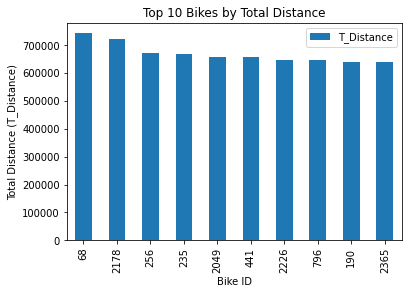

In [18]:
import matplotlib.pyplot as plt

group_bike_pd.plot(x='bike_id', y='T_Distance', kind='bar')
plt.xlabel("Bike ID")
plt.ylabel("Total Distance (T_Distance)")
plt.title("Top 10 Bikes by Total Distance")


In [23]:
group_bike_pd = group_bike_pd.sort_values(by='T_Distance', ascending=False)

top_10 = group_bike_pd.head(10)

print("Top 10 Bikes by Total Distance:")
print(top_10[['T_Distance']])

Top 10 Bikes by Total Distance:
   T_Distance
0   743369.39
1   721182.22
2   671916.00
3   670162.09
4   656828.08
5   656642.33
6   647823.24
7   646867.81
8   640294.24
9   639412.80
